<a href="https://colab.research.google.com/github/MNLepage08/YCNG-233/blob/main/Time_Series_Course_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install adapt

In [ ]:
!pip install keras-beats

In [ ]:
!pip install scikeras

In [4]:
import pandas as pd
import numpy as np
from datetime import timedelta, date, datetime
import time
import itertools
import os

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.dates as mdate

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(2)

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, TimeDistributed
from keras import layers, initializers, regularizers
from keras import backend as K
from keras.losses import MeanSquaredError

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from scikeras.wrappers import KerasRegressor
import random

from sklearn.linear_model import RidgeClassifier
from adapt.utils import make_classification_da
from adapt.utils import make_regression_da
from adapt.instance_based import TrAdaBoost
from adapt.feature_based import ADDA

from kerasbeats import prep_time_series, NBeatsModel

from google.colab import drive

In [5]:
tf.keras.utils.set_random_seed(66)
tf.random.set_seed(66)

In [6]:
from warnings import filterwarnings
filterwarnings('ignore')

# **Preprocess**

### Import Data

In [7]:
df_A = pd.read_csv('/content/HouseA_HW5.csv')
df_A.head()

,Date/Time,Consumption (kW)
0,11/29 01:00:00,25.838819
1,11/29 02:00:00,24.278115
2,11/29 03:00:00,23.928772
3,11/29 04:00:00,24.075874
4,11/29 05:00:00,23.865523


In [8]:
df_B = pd.read_csv('/content/HouseB_HW5.csv')
df_B.head()

,Date/Time,all
0,01/01 01:00:00,40.793727
1,01/01 02:00:00,41.837084
2,01/01 03:00:00,41.642094
3,01/01 04:00:00,42.812967
4,01/01 05:00:00,44.793965


In [9]:
df_C = pd.read_csv('/content/HouseC_HW5.csv')
df_C.head()

,Date/Time,all
0,01/01 01:00:00,31.905699
1,01/01 02:00:00,33.507795
2,01/01 03:00:00,33.627417
3,01/01 04:00:00,35.474427
4,01/01 05:00:00,35.959651


In [10]:
df_D = pd.read_csv('/content/HouseD_HW5.csv')
df_D.head()

,Date/Time,All
0,01/01 01:00:00,17.540900
1,01/01 02:00:00,17.092382
2,01/01 03:00:00,16.768862
3,01/01 04:00:00,16.972979
4,01/01 05:00:00,17.180736


In [11]:
df_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         792 non-null    object 
 1   Consumption (kW)  792 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.5+ KB


In [12]:
df_B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/Time  8016 non-null   object 
 1   all        8016 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.4+ KB


In [13]:
df_C.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/Time  8016 non-null   object 
 1   all        8016 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.4+ KB


In [14]:
df_D.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8016 entries, 0 to 8015
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/Time  8016 non-null   object 
 1   All        8016 non-null   float64
dtypes: float64(1), object(1)
memory usage: 125.4+ KB


In [15]:
# Set a date format in the index
df_A['month'] = df_A['Date/Time'].str[:3]
df_A['day'] = df_A['Date/Time'].str[4:6]
df_A['hour'] = df_A['Date/Time'].str[8:10]
df_A['year'] = "2021"

df_A["Date"] = pd.to_datetime(df_A[['month', 'day', 'year', 'hour']])
df_A.set_index('Date', inplace=True)
df_A = df_A.drop(columns=['Date/Time', 'month','day','hour','year'])

# Check if we have null data
print(df_A.isnull().any())
print('\n')

# Duplicate data
print(df_A[df_A.duplicated(keep=False)])

Consumption (kW)    False
dtype: bool


Empty DataFrame
Columns: [Consumption (kW)]
Index: []


In [16]:
# Set a date format in the index
df_B['month'] = df_B['Date/Time'].str[:3]
df_B['day'] = df_B['Date/Time'].str[4:6]
df_B['hour'] = df_B['Date/Time'].str[8:10]
df_B['year'] = "2021"

df_B["Date"] = pd.to_datetime(df_B[['month', 'day', 'year', 'hour']])
df_B.set_index('Date', inplace=True)
df_B = df_B.drop(columns=['Date/Time', 'month','day','hour','year'])

# Check if we have null data
print(df_B.isnull().any())
print('\n')

# Duplicate data
print(df_B[df_B.duplicated(keep=False)])

all    False
dtype: bool


Empty DataFrame
Columns: [all]
Index: []


In [17]:
# Set a date format in the index
df_C['month'] = df_C['Date/Time'].str[:3]
df_C['day'] = df_C['Date/Time'].str[4:6]
df_C['hour'] = df_C['Date/Time'].str[8:10]
df_C['year'] = "2021"

df_C["Date"] = pd.to_datetime(df_C[['month', 'day', 'year', 'hour']])
df_C.set_index('Date', inplace=True)
df_C = df_C.drop(columns=['Date/Time', 'month','day','hour','year'])

# Check if we have null data
print(df_C.isnull().any())
print('\n')

# Duplicate data
print(df_C[df_C.duplicated(keep=False)])

all    False
dtype: bool


                          all
Date                         
2021-06-06 02:00:00  1.321133
2021-09-28 02:00:00  1.321133


In [18]:
df_C.loc[df_C.index >= '2021-06-06 00:00:00'].head()

,all
Date,
2021-06-06 00:00:00,1.923141
2021-06-06 01:00:00,1.503994
2021-06-06 02:00:00,1.321133
2021-06-06 03:00:00,1.298890
2021-06-06 04:00:00,1.359511


In [19]:
df_C.loc[df_C.index >= '2021-09-28 00:00:00'].head()

,all
Date,
2021-09-28 00:00:00,1.921791
2021-09-28 01:00:00,1.499787
2021-09-28 02:00:00,1.321133
2021-09-28 03:00:00,1.298992
2021-09-28 04:00:00,1.359686


In [20]:
# Set a date format in the index
df_D['month'] = df_D['Date/Time'].str[:3]
df_D['day'] = df_D['Date/Time'].str[4:6]
df_D['hour'] = df_D['Date/Time'].str[8:10]
df_D['year'] = "2021"

df_D["Date"] = pd.to_datetime(df_D[['month', 'day', 'year', 'hour']])
df_D.set_index('Date', inplace=True)
df_D = df_D.drop(columns=['Date/Time', 'month','day','hour','year'])

# Check if we have null data
print(df_D.isnull().any())
print('\n')

# Duplicate data
print(df_D[df_D.duplicated(keep=False)])

All    False
dtype: bool


Empty DataFrame
Columns: [All]
Index: []


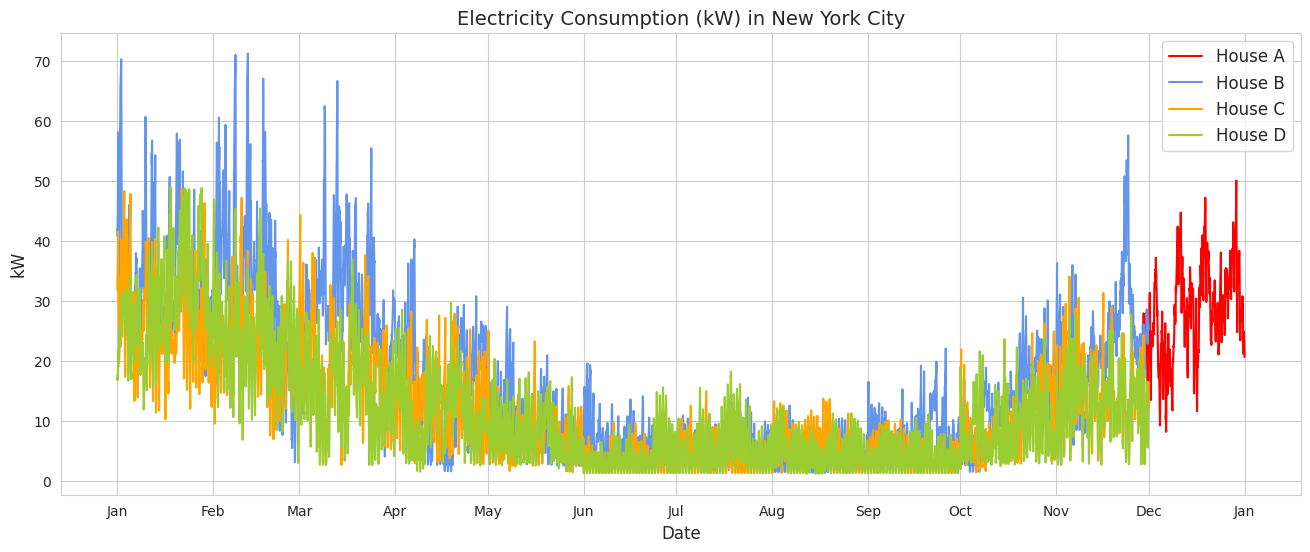

In [21]:
plt.figure(figsize = (16,6))
plt.plot(df_A, color='Red', label="House A")
plt.plot(df_B, color='cornflowerblue', label="House B")
plt.plot(df_C, color='Orange', label="House C")
plt.plot(df_D, color='YellowGreen', label='House D')
plt.xlabel('Date', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Electricity Consumption (kW) in New York City', size = 14)
plt.legend(loc = 'upper right', fontsize="12")

locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

plt.show()

* The data are on different dates. House B, C, D are set from January to November, while house A dates are from November 29 to December.

* For the preprocessing step, I have corrected the date format with datetime. I didn't notice any dplicate or missing values from the dataset.

* Perharps we can detect some anomalies in time series using various methods. But for the moment, I don't pass time on this question.

* The time series are non-stationary. Trend and seasonality can be observed.

* The problem consists in forecasting the next hour (the horizon) for each 1-hour step on December data, with a history of 4 lags prior to the December data set.

### Correlation

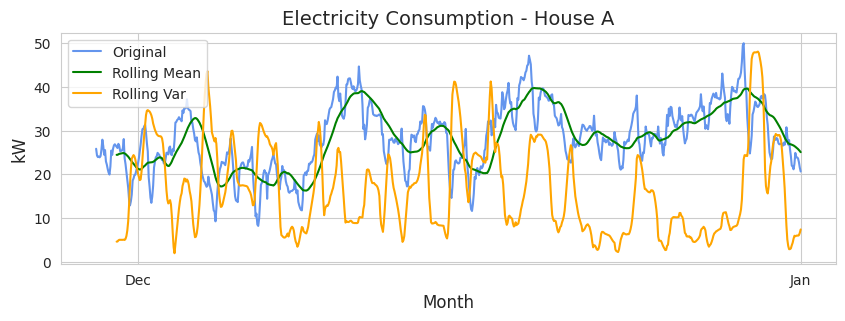

In [22]:
rolling_mean = df_A.rolling(window=24).mean()
rolling_var = df_A.rolling(window=24).var()

plt.figure(figsize = (10,3))
plt.plot(df_A, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Month', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Electricity Consumption - House A', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%b'))
#plt.gcf().autofmt_xdate()

plt.show()

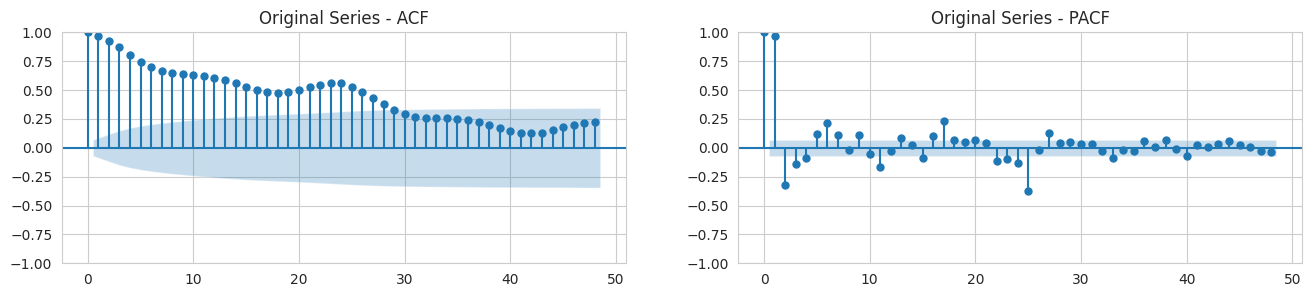

In [23]:
fig, ax = plt.subplots(1,2,figsize=(16,3))

plot_acf(df_A, lags=48, title='Original Series - ACF', ax=ax[0])
plot_pacf(df_A, lags=48, title='Original Series - PACF', ax=ax[1])
plt.show()

1st Order Differencing --> Trend d = 1

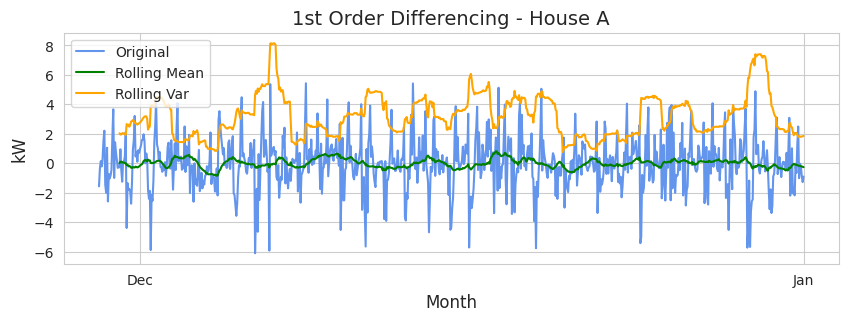

In [24]:
rolling_mean = df_A.diff().dropna().rolling(window=24).mean()
rolling_var = df_A.diff().dropna().rolling(window=24).var()

plt.figure(figsize = (10,3))
plt.plot(df_A.diff().dropna(), color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Month', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('1st Order Differencing - House A', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%b'))
#plt.gcf().autofmt_xdate()

plt.show()

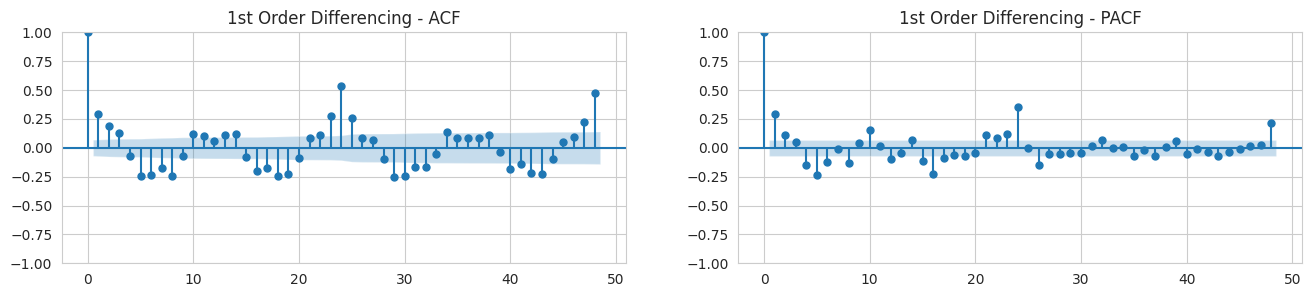

In [25]:
fig, ax = plt.subplots(1,2,figsize=(16,3))

plot_acf(df_A.diff().dropna(), lags=48, title='1st Order Differencing - ACF', ax=ax[0])
plot_pacf(df_A.diff().dropna(), lags=48, title='1st Order Differencing - PACF', ax=ax[1])
plt.show()

Seasonal Differencing

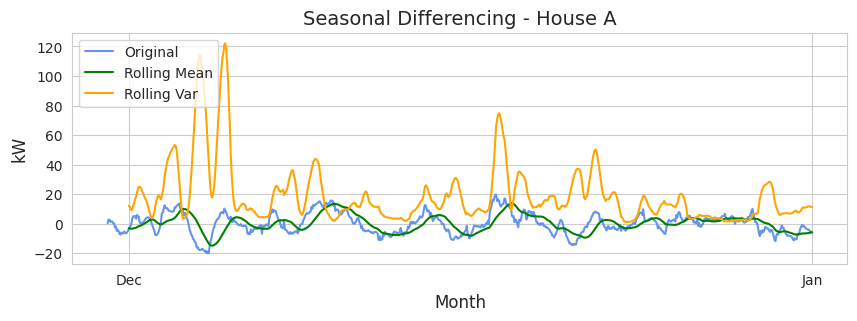

In [26]:
t = df_A - df_A.shift(24)
rolling_mean = t.rolling(window=24).mean()
rolling_var = t.rolling(window=24).var()

plt.figure(figsize = (10,3))
plt.plot(t.dropna(), color='cornflowerblue',label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Month', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Seasonal Differencing - House A', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%b'))
#plt.gcf().autofmt_xdate()

plt.show()

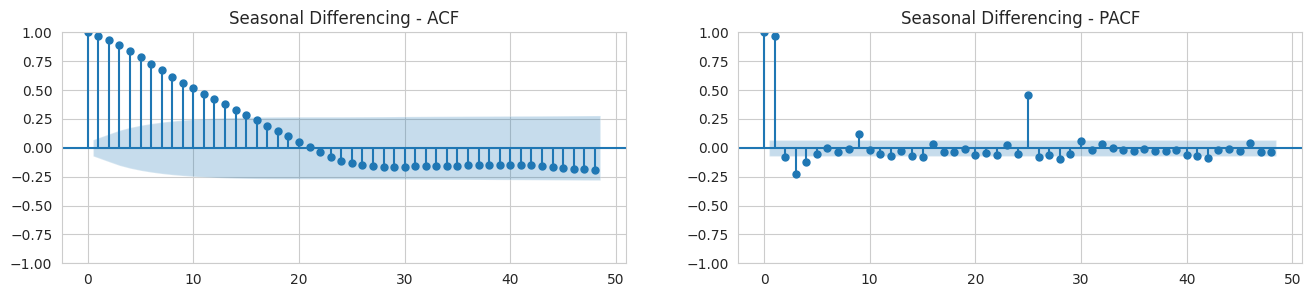

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,3))

plot_acf(t.dropna(), lags=48, title='Seasonal Differencing - ACF', ax=ax[0])
plot_pacf(t.dropna(), lags=48, title='Seasonal Differencing - PACF', ax=ax[1])
plt.show()

1st Order Seasonnal Differencing --> D = 1


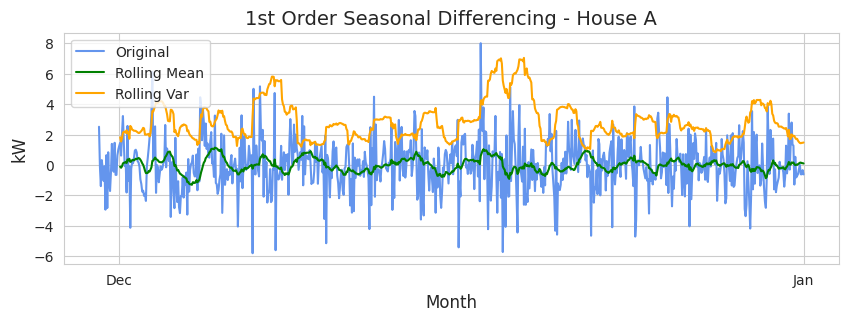

In [28]:
rolling_mean = t.diff().dropna().rolling(window=24).mean()
rolling_var = t.diff().dropna().rolling(window=24).var()

plt.figure(figsize = (10,3))
plt.plot(t.diff().dropna(), color='cornflowerblue',label='Original')
plt.plot(rolling_mean, color='green', label='Rolling Mean')
plt.plot(rolling_var, color='orange', label='Rolling Var')
plt.xlabel('Month', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('1st Order Seasonal Differencing - House A', size = 14)
plt.legend(loc = 'upper left')

locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%b'))
#plt.gcf().autofmt_xdate()

plt.show()

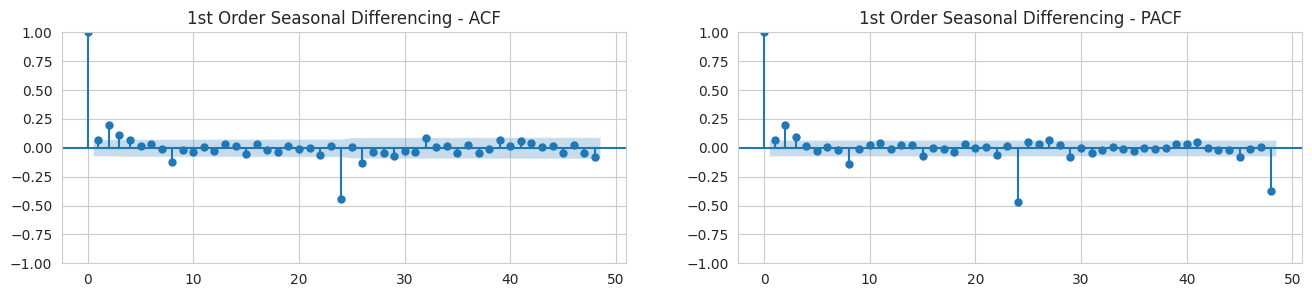

In [29]:
fig, ax = plt.subplots(1,2,figsize=(16,3))

plot_acf(t.diff().dropna(), lags=48, title='1st Order Seasonal Differencing - ACF', ax=ax[0])
plot_pacf(t.diff().dropna(), lags=48, title='1st Order Seasonal Differencing - PACF', ax=ax[1])
plt.show()

The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1)12 model will show:

*  a spike at lag 12 in the ACF but no other significant spikes;
*  exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).

Similarly, an ARIMA(0,0,0)(1,0,0)12 model will show:

*   exponential decay in the seasonal lags of the ACF;
*   a single significant spike at lag 12 in the PACF.

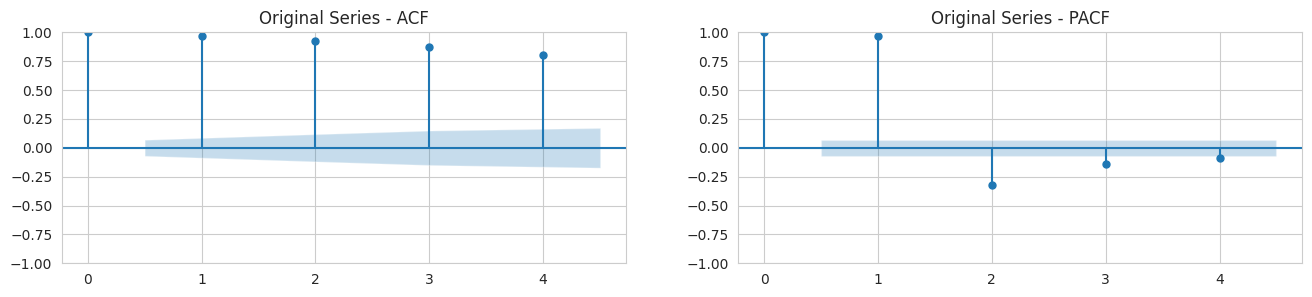

In [30]:
fig, ax = plt.subplots(1,2,figsize=(16,3))

plot_acf(df_A, lags=4, title='Original Series - ACF', ax=ax[0])
plot_pacf(df_A, lags=4, title='Original Series - PACF', ax=ax[1])
plt.show()

The problem is that we are using now. windowws size of 4. ARIMA models require enough data to capture meaningful patterns and dynamics. If the window size is too small, the model doesn't estimate the parameters accurately and return a prediction similar to the last observed value. For this reason, I consider time series without trend or seasonality on windows size of 4.

### Function for graph, lags, RMSE, History

In [32]:
def create_lag(lags, table_tb, kind=None, scale=None):

    #global train_ml_X, train_ml_Y, valid_ml_X, valid_ml_Y, test_ml_X, test_ml_Y, train_ml_X_rs, valid_ml_X_rs, test_ml_X_rs, df_lag
    global train_valid_ml_X, train_valid_ml_Y, test_ml_X, test_ml_Y, train_valid_ml_X_rs, test_ml_X_rs, df_lag

    p = lags
    #df_lag = pd.concat([train_tb, test_tb])
    df_lag = table_tb.copy()
    l = list(range(1, p+1))
    for i in l:
      if scale == "yes":
        df_lag[f'lag_{i}'] = df_lag['Scaled'].shift(i)
      else:
        df_lag[f'lag_{i}'] = df_lag['Consumption (kW)'].shift(i)

    h=1
    for i in range(0, h):
      if scale == "yes":
        df_lag[f'out_{i}'] = df_lag['Scaled'].shift(i)
      else:
        df_lag[f'out_{i}'] = df_lag['Consumption (kW)'].shift(i)

    if scale == "yes":
        df_lag = df_lag.drop('Scaled',axis=1)
    else:
        df_lag = df_lag.drop('Consumption (kW)',axis=1)


    train_valid_ml = df_lag.loc[(df_lag.index.get_level_values(0) <= '2021-12-01 00:00:00')]
    test_ml = df_lag.loc[(df_lag.index.get_level_values(0) > '2021-12-01 00:00:00')]

    train_valid_ml_copy = train_valid_ml.copy()
    train_valid_ml_copy.dropna(axis=0, inplace=True)
    test_ml_copy = test_ml.copy()
    test_ml_copy.dropna(axis=0, inplace=True)

    train_valid_ml_X = train_valid_ml_copy[[x for x in list(train_valid_ml_copy) if 'lag' in x]]
    train_valid_ml_Y = train_valid_ml_copy[[x for x in list(train_valid_ml_copy) if 'out_0' in x]]
    test_ml_X = test_ml_copy[[x for x in list(test_ml_copy) if 'lag' in x]]
    test_ml_Y = test_ml_copy[[x for x in list(test_ml_copy) if 'out_0' in x]]

    # Finally not use LSTM
    if kind == 'LSTM':
      train_valid_ml_X = train_valid_ml_X.values
      test_ml_X = test_ml_X.values

      train_valid_ml_X_rs = train_valid_ml_X.reshape(train_valid_ml_X.shape[0], 1, p)
      test_ml_X_rs = test_ml_X.reshape(test_ml_X.shape[0], 1, p)

      return train_valid_ml_X_rs, train_valid_ml_Y, test_ml_X_rs, test_ml_Y

    else:
      return train_valid_ml_X, train_valid_ml_Y, test_ml_X, test_ml_Y

In [33]:
def RMSE(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [34]:
def MSE(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [35]:
def history_graph():

  #plt.figure(figsize=(8,3))
  plt.figure(figsize=(8,3))
  plt.plot(history.history['loss'], label='Training')
  plt.plot(history.history['val_loss'], label='Valuation')
  plt.title('RMSE - ' + str(title), fontsize=18)
  plt.grid(True)
  plt.legend(fontsize=12)

In [36]:
def history_df(tbl):

  global dfh
  dfh = pd.DataFrame()

  for i, history in enumerate(history_list):

      temp_df = pd.DataFrame(history.history)
      temp_df['Iteration'] = i+1
      dfh = pd.concat([dfh, temp_df])

  dfh.rename(columns={'index': 'Epoch'}, inplace=True)

  return dfh

# **Task 1**

Only use the two days of November of house A as the training data and report the performance on the testing set of house A (December). Please note that you should report the performance of different models including deep feedforward neural networks, LSTM-based model, linear regression, repeat the last one, and at least one statistical method. You can also try to test more methods for this problem.

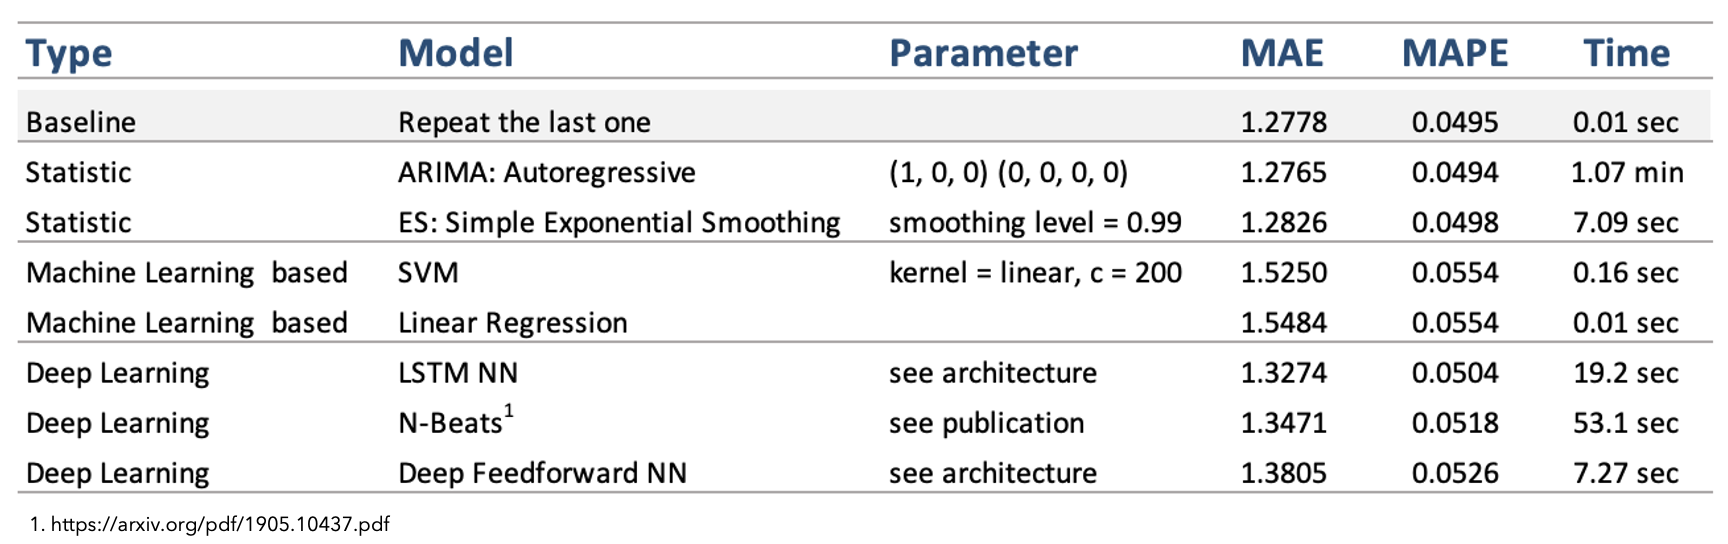

* No model outperforms the baseline
* Baseline = Statistical > Deep Learning > Machine Learning based approach
* Let's try some transfer learning methods

### Repeat the last one

In [37]:
RP = pd.DataFrame()

st = time.time()

for i in range(1,2):
    RP[f'lag_{i}'] = df_A['Consumption (kW)'].shift(i)
RP['out'] = df_A['Consumption (kW)']

et = time.time()
elapsed_time = et - st
print(timedelta(seconds=elapsed_time))

0:00:00.014786


In [38]:
RLO = RP.loc[RP.index > '2021-12-01 00:00:00']

print(RLO.head())
print(RLO.tail())

                         lag_1        out
Date                                     
2021-12-01 01:00:00  22.492288  23.675968
2021-12-01 02:00:00  23.675968  25.239773
2021-12-01 03:00:00  25.239773  26.844480
2021-12-01 04:00:00  26.844480  28.815815
2021-12-01 05:00:00  28.815815  30.333043
                         lag_1        out
Date                                     
2021-12-31 20:00:00  23.880643  23.850543
2021-12-31 21:00:00  23.850543  23.654771
2021-12-31 22:00:00  23.654771  22.806547
2021-12-31 23:00:00  22.806547  21.532958
2022-01-01 00:00:00  21.532958  20.632155


In [39]:
print("MAE = " + str(mean_absolute_error(RLO["out"], RLO["lag_1"])))
print("MAPE = " + str(mean_absolute_percentage_error(RLO["out"], RLO["lag_1"])))

MAE = 1.2777831904758064
MAPE = 0.049544028991889456


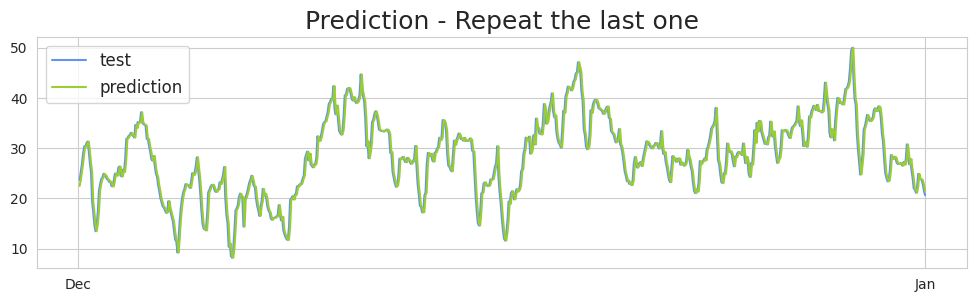

In [40]:
plt.figure(figsize=(12,3))
plt.title('Prediction - Repeat the last one', fontsize=18)
plt.plot(RLO["out"], color='cornflowerblue',label='test')
plt.plot(RLO["lag_1"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### SARIMA

In [43]:
List_Date = df_A.loc[(df_A.index.get_level_values(0) >= '2021-11-30 21:00:00')]
len(List_Date)

748

In [44]:
Train_Date = df_A.loc[(df_A.index.get_level_values(0) <= '2021-12-01 00:00:00')]
len(Train_Date)

48

In [46]:
prediction=[]
actual=[]
d=[]
st = time.time()

for i in range(len(Train_Date), len(df_A)):

    a = df_A.index.get_level_values(0)[i]

    trainn = df_A.loc[(df_A.index.get_level_values(0) < a)]
    testt = df_A.loc[(df_A.index.get_level_values(0) == a)]
    #print(trainn.tail(4))
    #print(testt)

    model = SARIMAX(trainn.tail(4), order = (1,0,0), seasonal_order=(0,0,0,0))
    model_fitted = model.fit(disp=0)
    preds = model_fitted.forecast(len(testt))

    prediction.append(float(preds.values))
    actual.append(float((testt['Consumption (kW)'].values)))
    d.append(a)


et = time.time()
elapsed_time = et - st

data = np.array([d,prediction,actual]).T
data1 = pd.DataFrame(data, columns=['date','p','a'])
data1.set_index('date', inplace=True)

print('MAE = ' + str(mean_absolute_error(data1['a'], data1['p'])))
print("MAPE = " + str(mean_absolute_percentage_error(data1['a'], data1['p'])))
print(timedelta(seconds=elapsed_time))

MAE = 1.2764795967528124
MAPE = 0.0493629857136625
0:00:35.224245


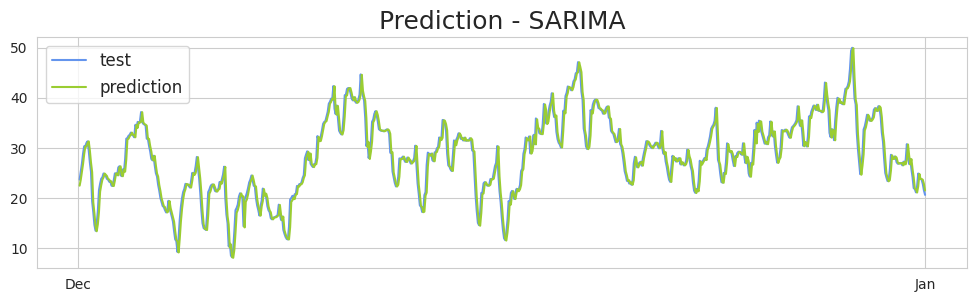

In [47]:
plt.figure(figsize=(12,3))
plt.title('Prediction - SARIMA', fontsize=18)
plt.plot(data1["a"], color='cornflowerblue',label='test')
plt.plot(data1["p"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

The autoregressive model with p=1 is the same as the last one with little noise.

### Exponential Smoothing: Holt-Winters

In [48]:
Train_Date = df_A.loc[(df_A.index.get_level_values(0) <= '2021-12-01 00:00:00')]
len(Train_Date)

48

In [49]:
List_Date = df_A.loc[(df_A.index.get_level_values(0) >= '2021-11-30 21:00:00')]
len(List_Date)

748

In [50]:
from statsmodels.tsa.api import SimpleExpSmoothing
st = time.time()

sm =  [1, 0.99]

for c in sm:

    prediction=[]
    actual=[]
    d=[]
    b=0
    st = time.time()

    for i in range(len(Train_Date), len(df_A)):

        a = df_A.index.get_level_values(0)[i]

        trainn_es = df_A.loc[(df_A.index.get_level_values(0) < a)]
        testt_es = df_A.loc[(df_A.index.get_level_values(0) == a)]

        #model = ExponentialSmoothing(trainn_es, trend=x, seasonal=y, seasonal_periods=24, freq="H")
        #model = ExponentialSmoothing(trainn_es.tail(4), trend="mul", seasonal_periods=24, freq="H", initialization_method=None)
        #print(trainn_es.tail(4))
        #print(testt_es)

        data = trainn_es.values[-4:].flatten()
        idx = trainn_es.index[-4:]
        edata = pd.Series(data, idx)

        model = SimpleExpSmoothing(edata)
        fit = model.fit(smoothing_level = c, optimized=False)
        #model = ExponentialSmoothing(edata, freq="H")

        #fit = model.fit()
        preds_optimized = fit.forecast(1)
        #print(edata, testt_es,preds_optimized)

        prediction.append(float(preds_optimized.values))
        actual.append(float((testt_es['Consumption (kW)'].values)))
        d.append(a)
        b = b+1

    et = time.time()
    elapsed_time = et - st

    data = np.array([d,prediction,actual]).T
    data1 = pd.DataFrame(data, columns=['date','p','a'])
    data1.set_index('date', inplace=True)

    print(c)
    #print('trend: ' + str(x) + ', seasonal: '+ str(y))
    print('MAE = ' + str(mean_absolute_error(data1['a'], data1['p'])))
    print("MAPE = " + str(mean_absolute_percentage_error(data1['a'], data1['p'])))
    print(timedelta(seconds=elapsed_time))
    print('\n')

1
MAE = 1.2777831904758064
MAPE = 0.049544028991889456
0:00:08.154488


0.99
MAE = 1.2825922319196563
MAPE = 0.04975433503243175
0:00:04.633076




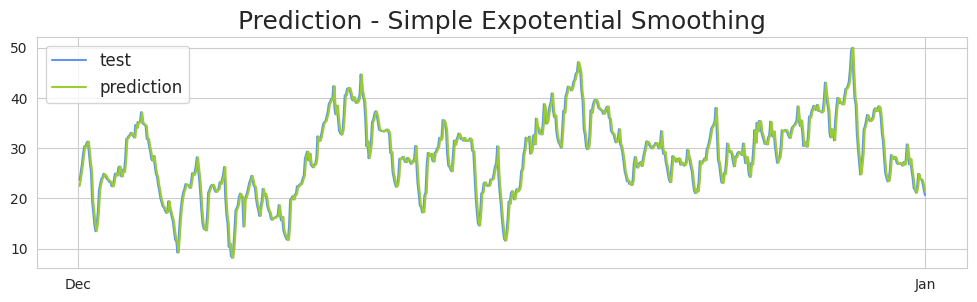

In [53]:
plt.figure(figsize=(12,3))
plt.title('Prediction - Simple Expotential Smoothing', fontsize=18)
plt.plot(data1["a"], color='cornflowerblue',label='test')
plt.plot(data1["p"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

I have used simple exponential smoothing, which ignores trend and seasonality. With a smoothing level of 1, the model predictions are equal to the last value.

### Linear Regression

In [54]:
create_lag(4, df_A, kind=None, scale=None)

st = time.time()

lr = LinearRegression()
lr.fit(train_valid_ml_X, train_valid_ml_Y)
preds = lr.predict(test_ml_X)

et = time.time()
elapsed_time = et - st

print('MAE = ' + str(mean_absolute_error(test_ml_Y.values, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(test_ml_Y.values, preds)))
print(timedelta(seconds=elapsed_time))

MAE = 1.5483841020852163
MAPE = 0.05543770562065529
0:00:00.023839


In [55]:
print(len(train_valid_ml_X),len(train_valid_ml_Y))
print(len(test_ml_X),len(test_ml_Y))

44 44
744 744


In [56]:
print("min = " + str(train_valid_ml_X.index.min()) + " max = " + str(train_valid_ml_X.index.max()))
print("min = " + str(train_valid_ml_Y.index.min()) + " max = " + str(train_valid_ml_Y.index.max()))
print('\n')
print("min = " + str(test_ml_X.index.min()) + " max = " + str(test_ml_X.index.max()))
print("min = " + str(test_ml_Y.index.min()) + " max = " + str(test_ml_Y.index.max()))

min = 2021-11-29 05:00:00 max = 2021-12-01 00:00:00
min = 2021-11-29 05:00:00 max = 2021-12-01 00:00:00


min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00
min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00


In [57]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = preds
df_preds.head()

,out_0,preds
Date,,
2021-12-01 01:00:00,23.675968,23.051274
2021-12-01 02:00:00,25.239773,24.140072
2021-12-01 03:00:00,26.844480,25.653808
2021-12-01 04:00:00,28.815815,27.133517
2021-12-01 05:00:00,30.333043,28.979919


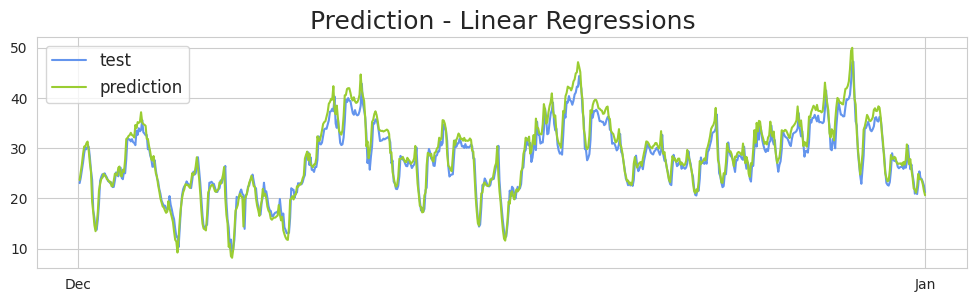

In [58]:
plt.figure(figsize=(12,3))
plt.title('Prediction - Linear Regressions', fontsize=18)
plt.plot(df_preds["preds"], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### SVM

In [59]:
create_lag(4, df_A, kind=None, scale=None)

dt = '2021-11-30 17:00:00'
train_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) < dt)]
train_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) < dt)]
valid_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) >= dt)]
valid_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) >= dt)]

st = time.time()

sv = MultiOutputRegressor(SVR(kernel='linear', C=200)) #C=50
sv.fit(train_mlx, train_mly)

et = time.time()
elapsed_time = et - st

preds_train = sv.predict(train_mlx)
preds_valid = sv.predict(valid_mlx)
preds_test = sv.predict(test_ml_X)

print('MAE = ' + str(mean_absolute_error(test_ml_Y, preds_test)))
print("MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, preds_test)))
print('\n')

print(timedelta(seconds=elapsed_time))

MAE = 1.5250359458997107
MAPE = 0.055387726843205816


0:00:00.336327


In [60]:
print(len(train_mlx),len(train_mly))
print(len(valid_mlx),len(valid_mly))
print(len(test_ml_X),len(test_ml_Y))

36 36
8 8
744 744


In [61]:
print("min = " + str(train_mlx.index.min()) + " max = " + str(train_mlx.index.max()))
print("min = " + str(train_mly.index.min()) + " max = " + str(train_mly.index.max()))
print('\n')
print("min = " + str(valid_mlx.index.min()) + " max = " + str(valid_mlx.index.max()))
print("min = " + str(valid_mly.index.min()) + " max = " + str(valid_mly.index.max()))
print('\n')
print("min = " + str(test_ml_X.index.min()) + " max = " + str(test_ml_X.index.max()))
print("min = " + str(test_ml_Y.index.min()) + " max = " + str(test_ml_Y.index.max()))

min = 2021-11-29 05:00:00 max = 2021-11-30 16:00:00
min = 2021-11-29 05:00:00 max = 2021-11-30 16:00:00


min = 2021-11-30 17:00:00 max = 2021-12-01 00:00:00
min = 2021-11-30 17:00:00 max = 2021-12-01 00:00:00


min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00
min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00


In [63]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = preds_test
df_preds.head()

,out_0,preds
Date,,
2021-12-01 01:00:00,23.675968,23.619735
2021-12-01 02:00:00,25.239773,24.809481
2021-12-01 03:00:00,26.844480,26.471114
2021-12-01 04:00:00,28.815815,28.063655
2021-12-01 05:00:00,30.333043,30.030883


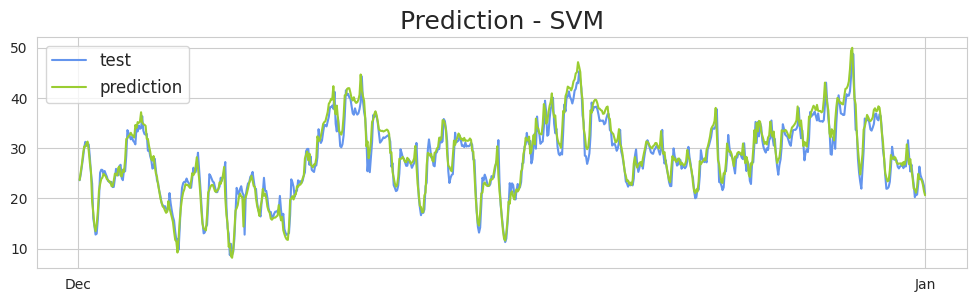

In [64]:
plt.figure(figsize=(12,3))
plt.title('Prediction - SVM', fontsize=18)
plt.plot(df_preds["preds"], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### Deep Feedforward Neural Network

24/24 [==============================] - 0s 1ms/step
MAE = 1.3805080174527282, MAPE = 0.052563131228667036
0:00:06.643657




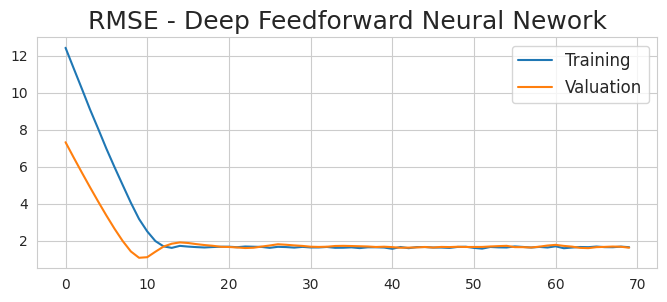

In [65]:
create_lag(4, df_A, kind=None, scale=None)

dt = '2021-11-30 17:00:00'
train_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) < dt)]
train_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) < dt)]
valid_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) >= dt)]
valid_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) >= dt)]


st = time.time()

model = Sequential()
model.add(Dense(3, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=4,
                    activation="linear", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=RMSE, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history=model.fit(train_mlx, train_mly, epochs=70,
                batch_size=8, verbose=0, shuffle=True, validation_data=(valid_mlx, valid_mly))

et = time.time()
elapsed_time = et - st

y_pred = model.predict(test_ml_X)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = "
           + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "Deep Feedforward Neural Nework"

print(testTxt)
print(timedelta(seconds=elapsed_time))
history_graph()
print('\n')

In [66]:
print(len(train_mlx),len(train_mly))
print(len(valid_mlx),len(valid_mly))
print(len(test_ml_X),len(test_ml_Y))

36 36
8 8
744 744


In [67]:
print("min = " + str(train_mlx.index.min()) + " max = " + str(train_mlx.index.max()))
print("min = " + str(train_mly.index.min()) + " max = " + str(train_mly.index.max()))
print('\n')
print("min = " + str(valid_mlx.index.min()) + " max = " + str(valid_mlx.index.max()))
print("min = " + str(valid_mly.index.min()) + " max = " + str(valid_mly.index.max()))
print('\n')
print("min = " + str(test_ml_X.index.min()) + " max = " + str(test_ml_X.index.max()))
print("min = " + str(test_ml_Y.index.min()) + " max = " + str(test_ml_Y.index.max()))

min = 2021-11-29 05:00:00 max = 2021-11-30 16:00:00
min = 2021-11-29 05:00:00 max = 2021-11-30 16:00:00


min = 2021-11-30 17:00:00 max = 2021-12-01 00:00:00
min = 2021-11-30 17:00:00 max = 2021-12-01 00:00:00


min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00
min = 2021-12-01 01:00:00 max = 2022-01-01 00:00:00


In [68]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = y_pred
df_preds.head()

,out_0,preds
Date,,
2021-12-01 01:00:00,23.675968,22.199995
2021-12-01 02:00:00,25.239773,23.430557
2021-12-01 03:00:00,26.844480,24.951223
2021-12-01 04:00:00,28.815815,26.648977
2021-12-01 05:00:00,30.333043,28.519060


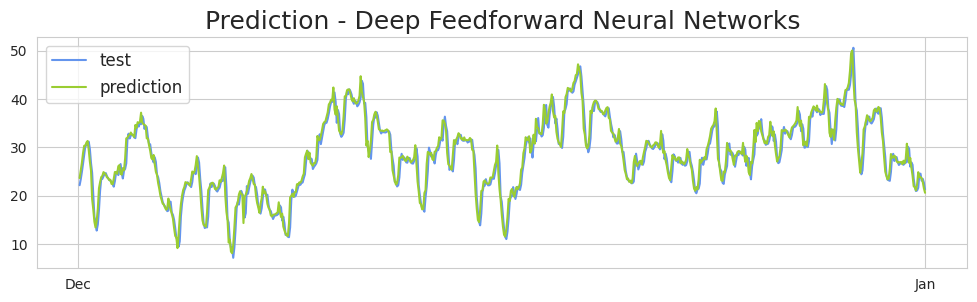

In [69]:
plt.figure(figsize=(12,3))
plt.title('Prediction - Deep Feedforward Neural Networks', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### LSTM

In [70]:
create_lag(4, df_A, kind=None, scale=None)

dt = '2021-11-30 17:00:00'
train_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) < dt)]
train_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) < dt)]
valid_mlx = train_valid_ml_X.loc[(train_valid_ml_X.index.get_level_values(0) >= dt)]
valid_mly = train_valid_ml_Y.loc[(train_valid_ml_Y.index.get_level_values(0) >= dt)]

train_mlx = train_mlx.values
valid_mlx = valid_mlx.values
test_mlx = test_ml_X.values

train_ml_X_rs = train_mlx.reshape(train_mlx.shape[0], 1, 4)
valid_ml_X_rs = valid_mlx.reshape(valid_mlx.shape[0], 1, 4)
test_ml_X_rs = test_mlx.reshape(test_mlx.shape[0], 1, 4)

In [71]:
print(len(train_ml_X_rs),len(train_mly))
print(len(valid_ml_X_rs),len(valid_mly))
print(len(test_ml_X_rs),len(test_ml_Y))

36 36
8 8
744 744


24/24 [==============================] - 0s 2ms/step
MAE = 1.3273617419740602, MAPE = 0.050386634412804825
0:00:14.271539




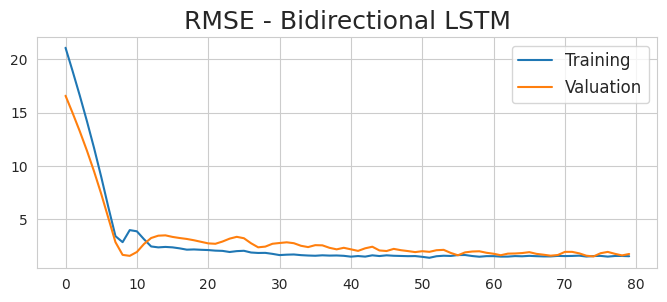

In [72]:
history_list =[]
st = time.time()

model = Sequential()
model.add(Bidirectional(LSTM(42, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
                               #input_shape=(1, 4), activation="linear", kernel_regularizer=keras.regularizers.l2(0.001), return_sequences=True)))
                               input_shape=(1, 4), activation="linear", kernel_regularizer=keras.regularizers.l2(0.001))))
#model.add(Bidirectional(LSTM(24, kernel_initializer=keras.initializers.glorot_uniform(seed=66),
#                                activation="linear")))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=RMSE, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history=model.fit(train_ml_X_rs, train_mly, epochs=80,
                batch_size=16, verbose=0, shuffle=True, validation_data=(valid_ml_X_rs, valid_mly))

et = time.time()
elapsed_time = et - st

history_list.append(history)

y_pred = model.predict(test_ml_X_rs)
testTxt = ("MAE = " + str(mean_absolute_error(test_ml_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_ml_Y, y_pred)))
title = "Bidirectional LSTM"

print(testTxt)
history_graph()
print(timedelta(seconds=elapsed_time))
print('\n')

In [73]:
df_preds = test_ml_Y.copy()
df_preds[f'preds'] = y_pred
df_preds.head()

,out_0,preds
Date,,
2021-12-01 01:00:00,23.675968,22.443155
2021-12-01 02:00:00,25.239773,23.638729
2021-12-01 03:00:00,26.844480,25.304873
2021-12-01 04:00:00,28.815815,27.004854
2021-12-01 05:00:00,30.333043,29.139229


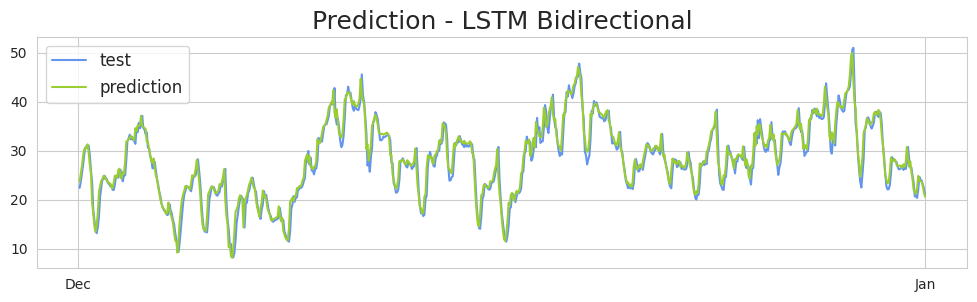

In [74]:
plt.figure(figsize=(12,3))
plt.title('Prediction - LSTM Bidirectional', fontsize=18)
plt.plot(df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### N-Beats

In [ ]:
df_A.sort_index(inplace = True)

In [ ]:
len(df_A.loc[(df_A.index.get_level_values(0) < '2021-12-01 01:00:00')])

48

In [ ]:
len(df_A)

792

In [ ]:
# prep a univariate time series for N-Beats
X, y = prep_time_series(df_A['Consumption (kW)'], lookback = 4, horizon = 1)

In [ ]:
X[0]

array([25.83881937, 24.27811542, 23.92877239, 24.0758738 ])

In [ ]:
y[0]

array([23.86552268])

In [ ]:
X_train = X[:44]
Y_train = y[:44]
X_test = X[44:]
Y_test= y[44:]

In [ ]:
print(len(X_train), len(X_test))
print(len(Y_train), len(Y_test))

44 744
44 744


In [ ]:
from numpy.random import seed
seed(66)
tf.random.set_seed(66)

In [ ]:
st = time.time()

nbeats = NBeatsModel(model_type = 'generic', lookback = 4, horizon = 1)
nbeats.fit(X_train, Y_train, epochs = 30)

et = time.time()
elapsed_time = et - st
print(timedelta(seconds=elapsed_time))

Epoch 1/30
1/1 [==============================] - 33s 33s/step - loss: 7.5940 - mae: 7.5940 - mape: 34.5375
Epoch 2/30
1/1 [==============================] - 0s 352ms/step - loss: 262.8318 - mae: 262.8318 - mape: 1218.1857
Epoch 3/30
1/1 [==============================] - 0s 369ms/step - loss: 56.4175 - mae: 56.4175 - mape: 254.8984
Epoch 4/30
1/1 [==============================] - 0s 343ms/step - loss: 27.6059 - mae: 27.6059 - mape: 125.9189
Epoch 5/30
1/1 [==============================] - 0s 366ms/step - loss: 6.3297 - mae: 6.3297 - mape: 29.5319
Epoch 6/30
1/1 [==============================] - 0s 385ms/step - loss: 11.0708 - mae: 11.0708 - mape: 50.8475
Epoch 7/30
1/1 [==============================] - 0s 371ms/step - loss: 2.0809 - mae: 2.0809 - mape: 9.8035
Epoch 8/30
1/1 [==============================] - 0s 357ms/step - loss: 5.8996 - mae: 5.8996 - mape: 26.4658
Epoch 9/30
1/1 [==============================] - 0s 381ms/step - loss: 3.6608 - mae: 3.6608 - mape: 17.0408
Epoch 1

In [ ]:
preds = nbeats.predict(X_test)
print('MAE = ' + str(mean_absolute_error(Y_test, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(Y_test, preds)))

24/24 [==============================] - 6s 137ms/step
MAE = 1.347138290343634
MAPE = 0.05177294857332918


The key idea behind the N-Beats model is to decompose the time series into a set of basic functions, which are then combined to generate forecasts. This decomposition allows the model to capture different patterns and dynamics in the data, making it highly flexible and interpretable.

# **Task 2**

Now assuming that besides house A, you also have data sets for house B, C, D, and you are free to use the data sets of house B, C, D as well the training set of house A. Can you try to come out a new solution and report its performance on the same test set on house A. Please note that the test set of house A should never be touched in the training phase.

https://medium.com/georgian-impact-blog/transfer-learning-part-1-ed0c174ad6e7

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

In [86]:
D = df_D.rename(columns={'All': 'Consumption (kW)'})
A = df_A.rename(columns={'all': 'Consumption (kW)'})
B = df_B.rename(columns={'all': 'Consumption (kW)'})
C = df_C.rename(columns={'all': 'Consumption (kW)'})

ABCD = pd.DataFrame()
ABCD = pd.concat([A, B, C, D], axis=0, keys=['A', 'B', 'C', 'D'], names=['Table'])
ABCD.head()

Consumption (kW)
Table Date                                 
A     2021-11-29 01:00:00         25.838819
      2021-11-29 02:00:00         24.278115
      2021-11-29 03:00:00         23.928772
      2021-11-29 04:00:00         24.075874
      2021-11-29 05:00:00         23.865523

In [76]:
print(len(ABCD))

24840


## **Naïve approach:** The simplest approach is to concatenate the datasets.

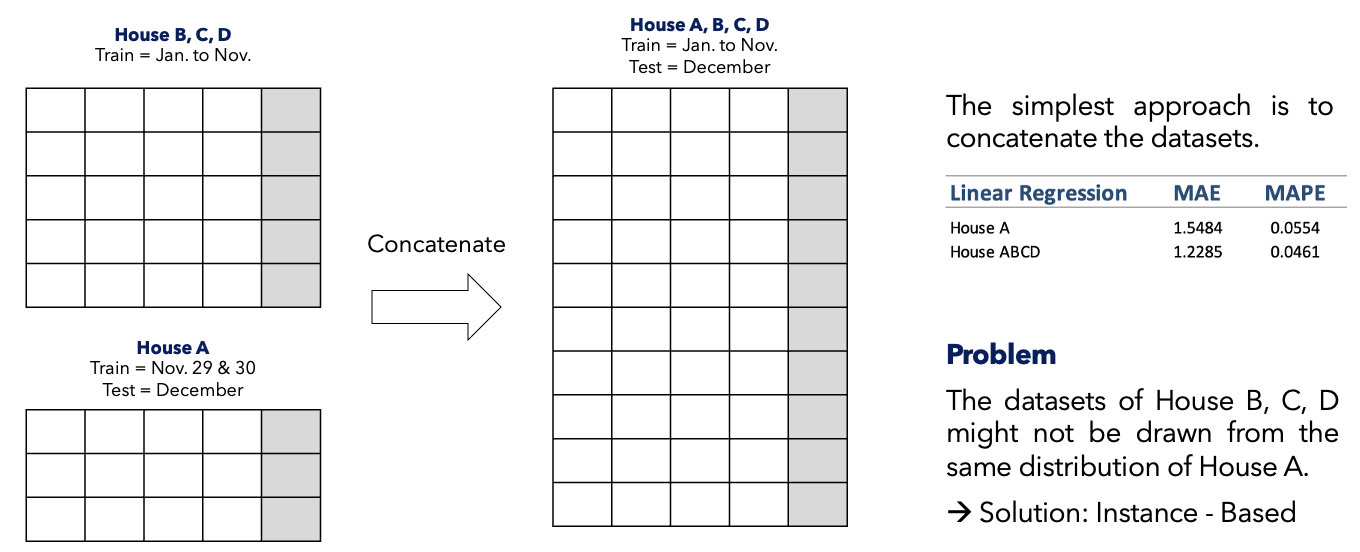

### Linear Regression:

In [87]:
p =4
l = list(range(1, p+1))
house = ["A","B","C","D"]
train_mlh_X, train_mlh_Y = pd.DataFrame(), pd.DataFrame()
test_mlh_X, test_mlh_Y  = pd.DataFrame(), pd.DataFrame()
dt = '2021-12-01 00:00:00'

for x in house:

  kind_house = ABCD.loc[(ABCD.index.get_level_values(0) == x)]
  tbl = pd.DataFrame()

  for i in l:
      tbl[f'lag_{i}'] = kind_house['Consumption (kW)'].shift(i)

  h=1
  for i in range(0, h):
      tbl[f'out_{i}'] = kind_house['Consumption (kW)'].shift(i)

  train_ml = tbl.loc[(tbl.index.get_level_values(1) <= dt)]
  test_ml = tbl.loc[(tbl.index.get_level_values(1) > dt)]

  train_ml.dropna(axis=0, inplace=True)
  test_ml.dropna(axis=0, inplace=True)

  train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
  train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
  test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
  test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]

  train_mlh_X = train_mlh_X.append(train_ml_X)
  train_mlh_Y = train_mlh_Y.append(train_ml_Y)
  test_mlh_X = test_mlh_X.append(test_ml_X)
  test_mlh_Y = test_mlh_Y.append(test_ml_Y)

In [88]:
print("min = " + str(train_mlh_X.index.min()) + " max = " + str(train_mlh_X.index.max()))
print("min = " + str(train_mlh_Y.index.min()) + " max = " + str(train_mlh_Y.index.max()))
print('\n')
print("min = " + str(test_mlh_X.index.min()) + " max = " + str(test_mlh_X.index.max()))
print("min = " + str(test_mlh_Y.index.min()) + " max = " + str(test_mlh_Y.index.max()))

min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))
min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))


min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))
min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))


In [89]:
print(len(train_mlh_X), len(train_mlh_Y))
print(len(test_mlh_X), len(test_mlh_Y))

24080 24080
744 744


In [90]:
st = time.time()

lr = LinearRegression()
lr.fit(train_mlh_X, train_mlh_Y)
preds = lr.predict(test_mlh_X)

et = time.time()
elapsed_time = et - st

print('MAE = ' + str(mean_absolute_error(test_mlh_Y.values, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(test_mlh_Y.values, preds)))
print(timedelta(seconds=elapsed_time))

MAE = 1.2284653401202346
MAPE = 0.04611394515979863
0:00:00.016107


### Deep Feedforward Neural Network

In [91]:
p =4
l = list(range(1, p+1))
house = ["A","B","C","D"]
dt_a = '2021-11-29 11:00:00'
dt_b = '2021-12-01 01:00:00'

train_mlh_X, train_mlh_Y = pd.DataFrame(), pd.DataFrame()
valid_mlh_X, valid_mlh_Y = pd.DataFrame(), pd.DataFrame()
test_mlh_X, test_mlh_Y  = pd.DataFrame(), pd.DataFrame()

for x in house:

  kind_house = ABCD.loc[(ABCD.index.get_level_values(0) == x)]
  tbl = pd.DataFrame()

  for i in l:
      tbl[f'lag_{i}'] = kind_house['Consumption (kW)'].shift(i)

  h=1
  for i in range(0, h):
      tbl[f'out_{i}'] = kind_house['Consumption (kW)'].shift(i)

  train_ml = tbl.loc[(tbl.index.get_level_values(1) < dt_a)]
  valid_ml = tbl.loc[(tbl.index.get_level_values(1) >= dt_a) &
                     (tbl.index.get_level_values(1) < dt_b)]
  test_ml = tbl.loc[(tbl.index.get_level_values(1) > dt_b)]

  train_ml.dropna(axis=0, inplace=True)
  valid_ml.dropna(axis=0, inplace=True)
  test_ml.dropna(axis=0, inplace=True)

  train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
  train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
  valid_ml_X = valid_ml[[x for x in list(valid_ml) if 'lag' in x]]
  valid_ml_Y = valid_ml[[x for x in list(valid_ml) if 'out' in x]]
  test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
  test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]

  train_mlh_X = train_mlh_X.append(train_ml_X)
  train_mlh_Y = train_mlh_Y.append(train_ml_Y)
  valid_mlh_X = valid_mlh_X.append(valid_ml_X)
  valid_mlh_Y = valid_mlh_Y.append(valid_ml_Y)
  test_mlh_X = test_mlh_X.append(test_ml_X)
  test_mlh_Y = test_mlh_Y.append(test_ml_Y)

In [92]:
print("min = " + str(train_mlh_X.index.min()) + " max = " + str(train_mlh_X.index.max()))
print("min = " + str(train_mlh_Y.index.min()) + " max = " + str(train_mlh_Y.index.max()))
print('\n')
print("min = " + str(valid_mlh_X.index.min()) + " max = " + str(valid_mlh_X.index.max()))
print("min = " + str(valid_mlh_Y.index.min()) + " max = " + str(valid_mlh_Y.index.max()))
print('\n')
print("min = " + str(test_mlh_X.index.min()) + " max = " + str(test_mlh_X.index.max()))
print("min = " + str(test_mlh_Y.index.min()) + " max = " + str(test_mlh_Y.index.max()))

min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-11-29 10:00:00'))
min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-11-29 10:00:00'))


min = ('A', Timestamp('2021-11-29 11:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))
min = ('A', Timestamp('2021-11-29 11:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))


min = ('A', Timestamp('2021-12-01 02:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))
min = ('A', Timestamp('2021-12-01 02:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))


In [93]:
print(len(train_mlh_X), len(train_mlh_Y))
print(len(valid_mlh_X), len(valid_mlh_Y))
print(len(test_mlh_X), len(test_mlh_Y))

23928 23928
152 152
743 743


24/24 [==============================] - 0s 1ms/step
MAE = 1.2025171851451983, MAPE = 0.045484217896314315
0:00:41.872851




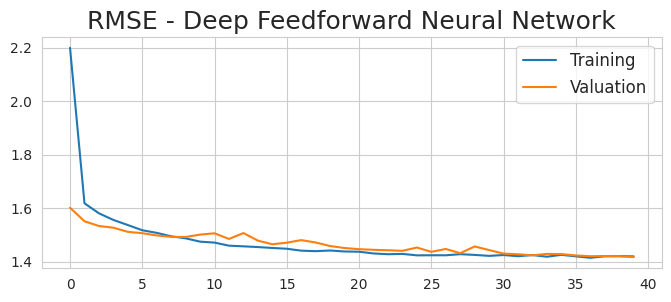

In [94]:
st = time.time()

model = Sequential()
model.add(Dense(3, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=p,
                    activation="linear", kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
model.compile(loss=RMSE, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

history=model.fit(train_mlh_X, train_mlh_Y, epochs=40,
                batch_size=64, verbose=0, validation_data=(valid_mlh_X, valid_mlh_Y))

et = time.time()
elapsed_time = et - st

y_pred = model.predict(test_mlh_X)
testTxt = ("MAE = " + str(mean_absolute_error(test_mlh_Y, y_pred)) + ", MAPE = " + str(mean_absolute_percentage_error(test_mlh_Y, y_pred)))

print(testTxt)
print(timedelta(seconds=elapsed_time))
title = "Deep Feedforward Neural Network"
history_graph()
print('\n')

In [95]:
df_preds = test_mlh_Y.copy()
df_preds[f'preds'] = y_pred
df_preds.head()

out_0      preds
Table Date                                     
A     2021-12-01 02:00:00  25.239773  24.276291
      2021-12-01 03:00:00  26.844480  25.993481
      2021-12-01 04:00:00  28.815815  27.657051
      2021-12-01 05:00:00  30.333043  29.744743
      2021-12-01 06:00:00  30.336479  31.141167

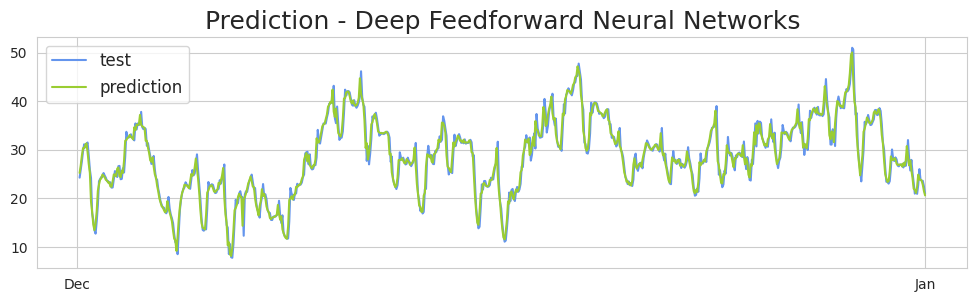

In [96]:
plt.figure(figsize=(12,3))
plt.title('Prediction - Deep Feedforward Neural Networks', fontsize=18)
plt.plot(df_preds.index.get_level_values(1),df_preds['preds'], color='cornflowerblue',label='test')
plt.plot(df_preds.index.get_level_values(1),df_preds["out_0"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

### N-Beats

N-BEATS is a neural-network based model for univariate timeseries forecasting.

https://medium.com/@jonathanbechtel/kerasbeats-an-easy-way-to-use-n-beats-in-keras-395b24c5cc28

In [ ]:
A.sort_index(inplace = True)
B.sort_index(inplace = True)
C.sort_index(inplace = True)
D.sort_index(inplace = True)

In [ ]:
XA, yA = prep_time_series(A['Consumption (kW)'], lookback = 4, horizon = 1)
XB, yB = prep_time_series(B['Consumption (kW)'], lookback = 4, horizon = 1)
XC, yC = prep_time_series(C['Consumption (kW)'], lookback = 4, horizon = 1)
XD, yD = prep_time_series(D['Consumption (kW)'], lookback = 4, horizon = 1)

In [ ]:
len(B.loc[(B.index.get_level_values(0) < '2021-12-01 01:00:00')])

8016

In [ ]:
XA_train = XA[:44]
YA_train = yA[:44]
XA_test = XA[44:]
YA_test= yA[44:]

XB_train = XB[:8016]
YB_train = yB[:8016]
XB_test = XB[8016:]
YB_test= yB[8016:]

XC_train = XC[:8016]
YC_train = yC[:8016]
XC_test = XC[8016:]
YC_test= yC[8016:]

XD_train = XD[:8016]
YD_train = yD[:8016]
XD_test = XD[8016:]
YD_test= yD[8016:]

In [ ]:
print(len(XA_train),len(YA_train))
print(len(XA_test),len(YA_test))

print(len(XB_train),len(YB_train))
print(len(XB_test),len(YB_test))

print(len(XC_train),len(YC_train))
print(len(XC_test),len(YC_test))

print(len(XD_train),len(YD_train))
print(len(XD_test),len(YD_test))

44 44
744 744
8012 8012
0 0
8012 8012
0 0
8012 8012
0 0


In [ ]:
X_train = np.concatenate((XA_train, XB_train, XC_train, XD_train))
Y_train = np.concatenate((YA_train, YB_train, YC_train, YD_train))
X_test = XA_test.copy()
Y_test = YA_test.copy()

In [ ]:
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

24080 24080
744 744


In [ ]:
nbeats = NBeatsModel(model_type = 'generic', lookback = 4, horizon = 1)
nbeats.fit(X_train, Y_train, epochs = 30)

Epoch 1/30
24/24 [==============================] - 110s 3s/step - loss: 10.4073 - mae: 10.4073 - mape: 168.2401
Epoch 2/30
24/24 [==============================] - 80s 3s/step - loss: 1.1072 - mae: 1.1072 - mape: 12.8772
Epoch 3/30
24/24 [==============================] - 74s 3s/step - loss: 1.0977 - mae: 1.0977 - mape: 12.6015
Epoch 4/30
24/24 [==============================] - 73s 3s/step - loss: 1.0920 - mae: 1.0920 - mape: 12.4542
Epoch 5/30
24/24 [==============================] - 74s 3s/step - loss: 1.1052 - mae: 1.1052 - mape: 12.7625
Epoch 6/30
24/24 [==============================] - 73s 3s/step - loss: 1.1060 - mae: 1.1060 - mape: 12.7630
Epoch 7/30
24/24 [==============================] - 74s 3s/step - loss: 1.1024 - mae: 1.1024 - mape: 12.7120
Epoch 8/30
24/24 [==============================] - 74s 3s/step - loss: 1.1263 - mae: 1.1263 - mape: 13.1556
Epoch 9/30
24/24 [==============================] - 76s 3s/step - loss: 1.0901 - mae: 1.0901 - mape: 12.4369
Epoch 10/30
24/

In [ ]:
preds = nbeats.predict(X_test)
print('MAE = ' + str(mean_absolute_error(Y_test, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(Y_test, preds)))

24/24 [==============================] - 10s 88ms/step
MAE = 1.2740418835768201
MAPE = 0.049412960476266914


## **Instance-Based:** Reweight instances in order to correct source and target distribution


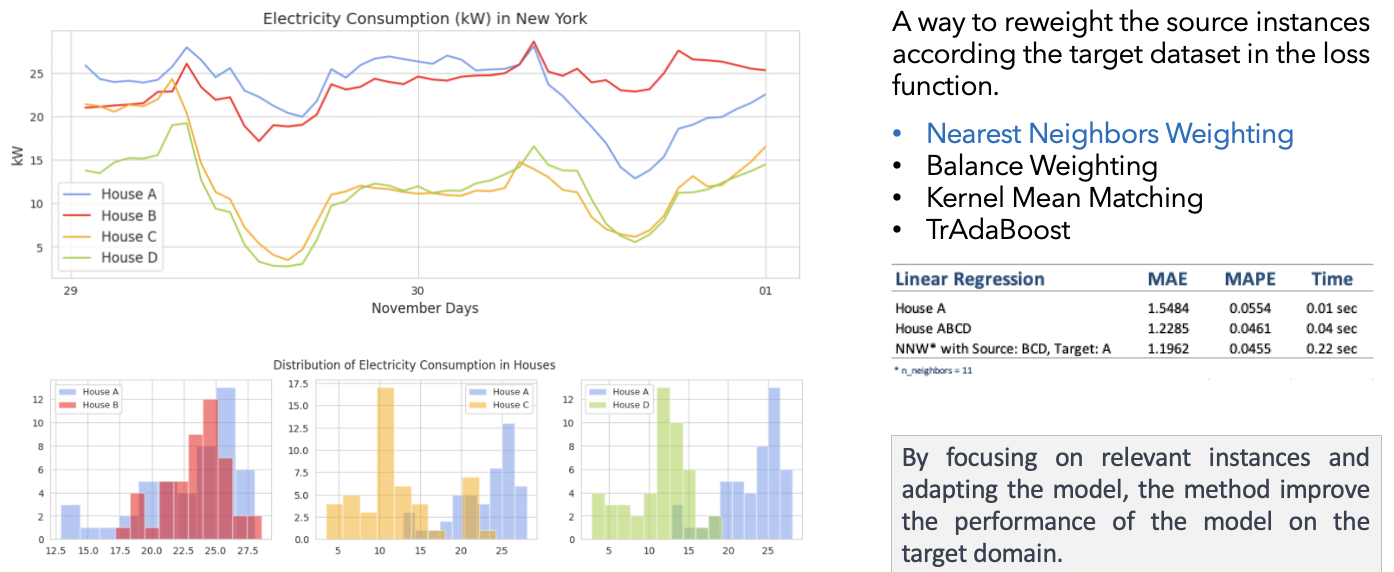

NNW: https://adapt-python.github.io/adapt/generated/adapt.instance_based.NearestNeighborsWeighting.html

Balanced Weighting: https://adapt-python.github.io/adapt/generated/adapt.instance_based.BalancedWeighting.html#adapt-instance-based-balancedweighting

KMM: https://adapt-python.github.io/adapt/generated/adapt.instance_based.KMM.html

TrAaBoost: https://adapt-python.github.io/adapt/generated/adapt.instance_based.TrAdaBoost.html#adapt-instance-based-tradaboost

In [99]:
#a = df_A.loc[(df_A.index.get_level_values(0))]
a = df_A.loc[(df_A.index.get_level_values(0) < '2021-12-01 01:00:00')]
b = df_B.loc[(df_B.index.get_level_values(0) >= '2021-11-29 01:00:00')]
c = df_C.loc[(df_C.index.get_level_values(0) >= '2021-11-29 01:00:00')]
d = df_D.loc[(df_D.index.get_level_values(0) >= '2021-11-29 01:00:00')]

d = d.rename(columns={'All': 'Consumption (kW)'})
a = a.rename(columns={'all': 'Consumption (kW)'})
b = b.rename(columns={'all': 'Consumption (kW)'})
c = c.rename(columns={'all': 'Consumption (kW)'})

abcd = pd.DataFrame()
abcd = pd.concat([a, b, c, d], axis=0, keys=['A', 'B', 'C', 'D'], names=['Table'])
abcd.head()

Consumption (kW)
Table Date                                 
A     2021-11-29 01:00:00         25.838819
      2021-11-29 02:00:00         24.278115
      2021-11-29 03:00:00         23.928772
      2021-11-29 04:00:00         24.075874
      2021-11-29 05:00:00         23.865523

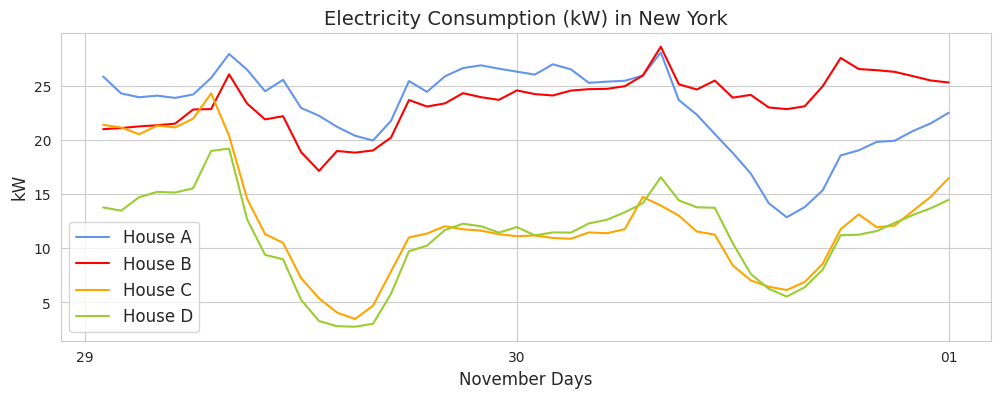

In [100]:
plt.figure(figsize = (12,4))

plt.plot(a, color='cornflowerblue', label="House A")
plt.plot(b, color='Red', label="House B")
plt.plot(c, color='Orange', label="House C")
plt.plot(d, color='YellowGreen', label='House D')
plt.xlabel('November Days', size = 12)
plt.ylabel('kW', size  = 12)
plt.title('Electricity Consumption (kW) in New York', size = 14)
plt.legend(loc = 'lower left', fontsize="12")

locator = mdate.DayLocator()  # every month
fmt = mdate.DateFormatter('%d')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

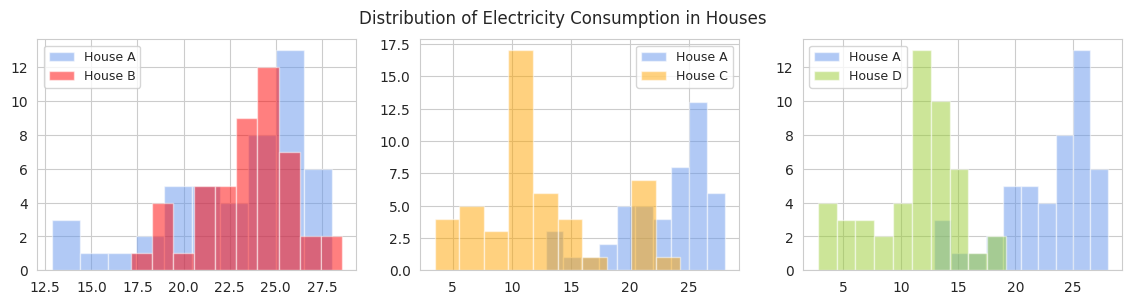

In [101]:
fig, axes =plt.subplots(1,3,figsize=(14,3))
fig.suptitle('Distribution of Electricity Consumption in Houses')

axes[0].hist(a, bins=10, alpha=0.5, label='House A', color='cornflowerblue')
axes[0].hist(b, bins=10, alpha=0.5, label='House B', color='red')
#axes[0].set_title("Distribution House A & B")
axes[0].legend(fontsize="9")

axes[1].hist(a, bins=10, alpha=0.5, label='House A', color='cornflowerblue')
axes[1].hist(c, bins=10, alpha=0.5, label='House C', color='orange')
#axes[1].set_title("Distribution House A & C")
axes[1].legend(fontsize="9")

axes[2].hist(a, bins=10, alpha=0.5, label='House A', color='cornflowerblue')
axes[2].hist(d, bins=10, alpha=0.5, label='House D', color='yellowgreen')
#axes[2].set_title("Distribution House A & D")
axes[2].legend(loc = 'upper left', fontsize="9")

plt.show

Time Series A, B, C, D --> different distribution but same space

### Linear Regression

In [102]:
p =4
l = list(range(1, p+1))
#house = ["A","B","C","D"]
house = ["B","C","D"]
source_X, source_Y = pd.DataFrame(), pd.DataFrame()

for x in house:

  kind_house = ABCD.loc[(ABCD.index.get_level_values(0) == x)]
  #kind_house = abcd.loc[(abcd.index.get_level_values(0) == x)]

  tbl = pd.DataFrame()

  for i in l:
      tbl[f'lag_{i}'] = kind_house['Consumption (kW)'].shift(i)

  h=1
  for i in range(0, h):
      tbl[f'out_{i}'] = kind_house['Consumption (kW)'].shift(i)

  train_ml = tbl.loc[(tbl.index.get_level_values(1) <= '2021-12-01 00:00:00')]
  train_ml.dropna(axis=0, inplace=True)

  train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
  train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]

  source_X = source_X.append(train_ml_X)
  source_Y = source_Y.append(train_ml_Y)

In [103]:
source_X.head()

lag_1      lag_2      lag_3      lag_4
Table Date                                                           
B     2021-01-01 05:00:00  42.812967  41.642094  41.837084  40.793727
      2021-01-01 06:00:00  44.793965  42.812967  41.642094  41.837084
      2021-01-01 07:00:00  48.787040  44.793965  42.812967  41.642094
      2021-01-01 08:00:00  56.919520  48.787040  44.793965  42.812967
      2021-01-01 09:00:00  58.048185  56.919520  48.787040  44.793965

In [104]:
print(len(source_X), len(source_Y))
print("min = " + str(source_X.index.min()) + " max = " + str(source_X.index.max()))
print("min = " + str(source_Y.index.min()) + " max = " + str(source_Y.index.max()))

24036 24036
min = ('B', Timestamp('2021-01-01 05:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))
min = ('B', Timestamp('2021-01-01 05:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))


In [105]:
p =4
l = list(range(1, p+1))
house = ["A","B","C","D"]
train_mlh_X, train_mlh_Y = pd.DataFrame(), pd.DataFrame()
test_mlh_X, test_mlh_Y  = pd.DataFrame(), pd.DataFrame()

for x in house[0]:

  kind_house = ABCD.loc[(ABCD.index.get_level_values(0) == x)]
  #kind_house = abcd.loc[(abcd.index.get_level_values(0) == x)]
  tbl = pd.DataFrame()

  for i in l:
      tbl[f'lag_{i}'] = kind_house['Consumption (kW)'].shift(i)

  h=1
  for i in range(0, h):
      tbl[f'out_{i}'] = kind_house['Consumption (kW)'].shift(i)

  train_ml = tbl.loc[(tbl.index.get_level_values(1) <= '2021-12-01 00:00:00')]
  test_ml = tbl.loc[(tbl.index.get_level_values(1) > '2021-12-01 00:00:00')]

  train_ml.dropna(axis=0, inplace=True)
  test_ml.dropna(axis=0, inplace=True)

  train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
  train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
  test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
  test_ml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]

  target_X = train_mlh_X.append(train_ml_X)
  target_Y = train_mlh_Y.append(train_ml_Y)
  test_mlh_X = test_mlh_X.append(test_ml_X)
  test_mlh_Y = test_mlh_Y.append(test_ml_Y)

In [106]:
print(len(target_X),len(target_Y))
print(len(test_mlh_X),len(test_mlh_Y))
print("min = " + str(target_X.index.min()) + " max = " + str(target_X.index.max()))
print("min = " + str(target_Y.index.min()) + " max = " + str(target_Y.index.max()))
print("min = " + str(test_mlh_X.index.min()) + " max = " + str(test_mlh_X.index.max()))
print("min = " + str(test_mlh_Y.index.min()) + " max = " + str(test_mlh_Y.index.max()))

44 44
744 744
min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('A', Timestamp('2021-12-01 00:00:00'))
min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('A', Timestamp('2021-12-01 00:00:00'))
min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))
min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))


#### House BCD (source), House A (target)

**KMM**

In [112]:
# https://adapt-python.github.io/adapt/generated/adapt.instance_based.KMM.html
from adapt.instance_based import KMM

Xs, ys, Xt, yt = make_regression_da()
model = KMM(LinearRegression(), Xt=target_X, kernel="rbf", verbose=0, random_state=0)
model.fit(source_X, source_Y)
s = model.score(target_X, target_Y)

print("Score = " + str(s))
preds = model.predict(test_mlh_X)
print("MAE = " + str(mean_absolute_error(test_mlh_Y, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(test_mlh_Y, preds)))

Score = 0.846751064060323
MAE = 1.2226367133546012
MAPE = 0.04642743156251422


**Nearest Neighbors Weighting**

In [108]:
# https://adapt-python.github.io/adapt/generated/adapt.instance_based.NearestNeighborsWeighting.html
from adapt.instance_based import NearestNeighborsWeighting

st = time.time()

Xs, ys, Xt, yt = make_classification_da()
model = NearestNeighborsWeighting(LinearRegression(), n_neighbors=11, Xt=target_X, random_state=0)
model.fit(source_X, source_Y)

et = time.time()
elapsed_time = et - st

s = model.score(target_X, target_Y)

print("Score = " + str(s))
preds = model.predict(test_mlh_X)
print("MAE = " + str(mean_absolute_error(test_mlh_Y, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(test_mlh_Y, preds)))
print(timedelta(seconds=elapsed_time))

Fit weights...
Fit Estimator...
Score = 0.8508543731700606
MAE = 1.1961631419090555
MAPE = 0.04552929995519263
0:00:00.173418


In [109]:
df_preds = test_mlh_Y.copy()
df_preds[f'preds'] = preds
df_preds.head()

out_0      preds
Table Date                                     
A     2021-12-01 01:00:00  23.675968  23.003195
      2021-12-01 02:00:00  25.239773  24.265555
      2021-12-01 03:00:00  26.844480  25.974720
      2021-12-01 04:00:00  28.815815  27.617608
      2021-12-01 05:00:00  30.333043  29.718941

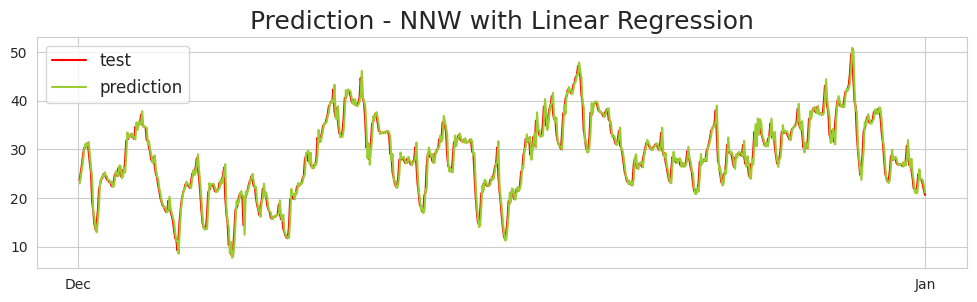

In [110]:
plt.figure(figsize=(12,3))
plt.title('Prediction - NNW with Linear Regression', fontsize=18)
plt.plot(df_preds.index.get_level_values(1),df_preds["out_0"], color='red',label='test')
plt.plot(df_preds.index.get_level_values(1),df_preds["preds"], color='YellowGreen', label='prediction')
plt.legend(fontsize=12)
locator = mdate.MonthLocator()  # every month
fmt = mdate.DateFormatter('%b')
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(fmt)
plt.grid(True)

**Balanced Weighting**

In [111]:
# https://adapt-python.github.io/adapt/generated/adapt.instance_based.BalancedWeighting.html#adapt-instance-based-balancedweighting
from adapt.instance_based import BalancedWeighting

Xs, ys, Xt, yt = make_regression_da()
model = BalancedWeighting(LinearRegression(), gamma=0.5, Xt=target_X, yt=target_Y, verbose=0, random_state=0)
model.fit(source_X, source_Y)
s = model.score(target_X, target_Y)

print("Score = " + str(s))
preds = model.predict(test_mlh_X)
print("MAE = " + str(mean_absolute_error(test_mlh_Y, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(test_mlh_Y, preds)))

Score = 0.8555290809836539
MAE = 1.2096144559333277
MAPE = 0.04549526857926437


# **Stacking**

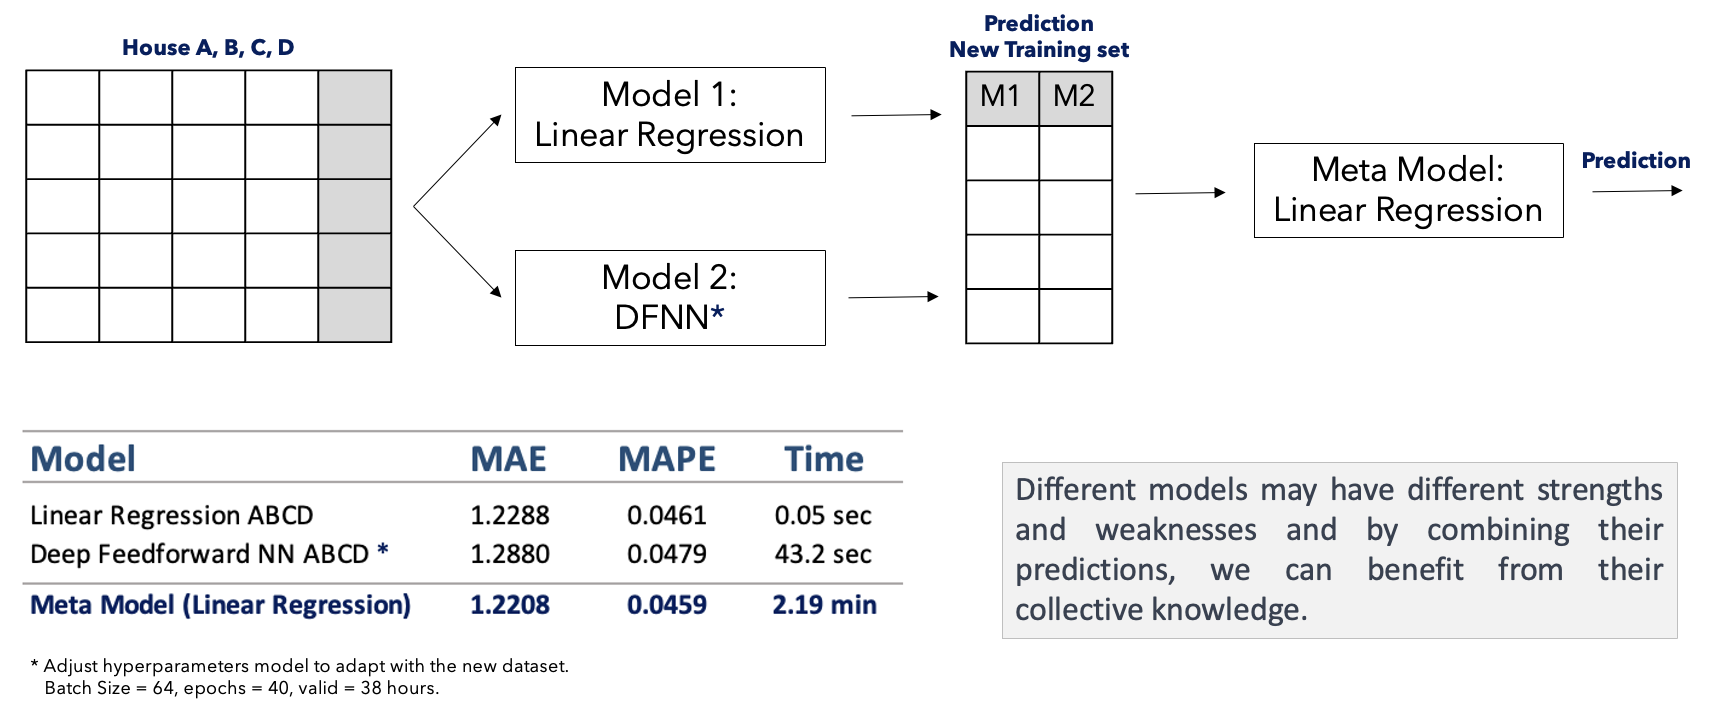

In [126]:
p =4
l = list(range(1, p+1))
house = ["A","B","C","D"]
dt_a = '2021-11-29 11:00:00'
dt_b = '2021-12-01 01:00:00'

sTrain_X, sTrain_Y = pd.DataFrame(), pd.DataFrame()
sValid_X, sValid_Y = pd.DataFrame(), pd.DataFrame()
sTest_X, sTest_Y = pd.DataFrame(), pd.DataFrame()

for x in house:

  kind_house = ABCD.loc[(ABCD.index.get_level_values(0) == x)]
  tbl = pd.DataFrame()

  for i in l:
      tbl[f'lag_{i}'] = kind_house['Consumption (kW)'].shift(i)

  h=1
  for i in range(0, h):
      tbl[f'out_{i}'] = kind_house['Consumption (kW)'].shift(i)

  train_ml = tbl.loc[(tbl.index.get_level_values(1) < dt_a)]
  valid_ml = tbl.loc[(tbl.index.get_level_values(1) >= dt_a) &
                     (tbl.index.get_level_values(1) < dt_b)]
  test_ml = tbl.loc[(tbl.index.get_level_values(1) >= dt_b)]

  train_ml.dropna(axis=0, inplace=True)
  valid_ml.dropna(axis=0, inplace=True)
  test_ml.dropna(axis=0, inplace=True)

  train_ml_X = train_ml[[x for x in list(train_ml) if 'lag' in x]]
  train_ml_Y = train_ml[[x for x in list(train_ml) if 'out' in x]]
  valid_ml_X = valid_ml[[x for x in list(valid_ml) if 'lag' in x]]
  valid_ml_Y = valid_ml[[x for x in list(valid_ml) if 'out' in x]]
  test_ml_X = test_ml[[x for x in list(test_ml) if 'lag' in x]]
  testml_Y = test_ml[[x for x in list(test_ml) if 'out' in x]]

  sTrain_X = sTrain_X.append(train_ml_X)
  sTrain_Y = sTrain_Y.append(train_ml_Y)
  sValid_X = sValid_X.append(valid_ml_X)
  sValid_Y = sValid_Y.append(valid_ml_Y)
  sTest_X = sTest_X.append(test_ml_X)
  sTest_Y = sTest_Y.append(testml_Y)

In [127]:
print("min = " + str(sTrain_X.index.min()) + " max = " + str(sTrain_X.index.max()))
print("min = " + str(sTrain_Y.index.min()) + " max = " + str(sTrain_Y.index.max()))
print('\n')
print("min = " + str(sValid_X.index.min()) + " max = " + str(sValid_X.index.max()))
print("min = " + str(sValid_Y.index.min()) + " max = " + str(sValid_Y.index.max()))
print('\n')
print("min = " + str(sTest_X.index.min()) + " max = " + str(sTest_X.index.max()))
print("min = " + str(sTest_Y.index.min()) + " max = " + str(sTest_Y.index.max()))

min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-11-29 10:00:00'))
min = ('A', Timestamp('2021-11-29 05:00:00')) max = ('D', Timestamp('2021-11-29 10:00:00'))


min = ('A', Timestamp('2021-11-29 11:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))
min = ('A', Timestamp('2021-11-29 11:00:00')) max = ('D', Timestamp('2021-12-01 00:00:00'))


min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))
min = ('A', Timestamp('2021-12-01 01:00:00')) max = ('A', Timestamp('2022-01-01 00:00:00'))


In [115]:
# Data Set for DFNN
print(len(sTrain_X), len(sTrain_Y))
print(len(sValid_X), len(sValid_Y))
print(len(sTest_X), len(sTest_Y))

23928 23928
152 152
744 744


In [128]:
def DFNN_ABCD():

  model = Sequential()
  model.add(Dense(3, kernel_initializer=keras.initializers.glorot_uniform(seed=66), input_dim=p,
                      activation="linear", kernel_regularizer=keras.regularizers.l2(0.001)))
  model.add(Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed=66)))
  model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

  #history=model.fit(train_mlh_X, train_mlh_Y, epochs=40,
  #                batch_size=64, verbose=0, validation_data=(valid_mlh_X, valid_mlh_Y))

  return model

In [129]:
model_DFNN_ABCD = KerasRegressor(build_fn=DFNN_ABCD, epochs=40, batch_size=64, verbose=0, random_state=60)

In [130]:
from sklearn.ensemble import StackingRegressor
st = time.time()

model_1 = LinearRegression()
model_4 = model_DFNN_ABCD

estimators = [("LR_ABCD", model_1),
              ("DFNN_ABCD", model_4)]

reg = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
reg.fit(sTrain_X, sTrain_Y)

et = time.time()
elapsed_time = et - st

preds = reg.predict(sTest_X)
print('MAE = ' + str(mean_absolute_error(sTest_Y, preds)))
print("MAPE = " + str(mean_absolute_percentage_error(sTest_Y, preds)))
print(timedelta(seconds=elapsed_time))

MAE = 1.2207601952616376
MAPE = 0.04591041388096631
0:02:52.661673


In [119]:
# Input in the meta model (linear regression)
reg.transform(test_mlh_X)

array([[22.79936527, 22.61676216],
       [24.06996081, 23.89761353],
       [25.78265057, 25.58768845],
       ...,
       [23.35794474, 23.24213791],
       [22.26407515, 22.12489128],
       [20.76723846, 20.61523438]])

In [120]:
# Input in model 1 (linear regression)
st = time.time()

model_1.fit(sTrain_X, sTrain_Y)

et = time.time()
elapsed_time = et - st

p=model_1.predict(sTest_X)
print(p[0])
print('MAE = ' + str(mean_absolute_error(sTest_Y, p)))
print("MAPE = " + str(mean_absolute_percentage_error(sTest_Y, p)))
print(timedelta(seconds=elapsed_time))

[22.79936527]
MAE = 1.2287878694001857
MAPE = 0.0461237463336959
0:00:00.027442


In [131]:
# Input in model 2 (DFNN)
st = time.time()

model_4.fit(sTrain_X, sTrain_Y)

et = time.time()
elapsed_time = et - st

p=model_4.predict(sTest_X)
print(p[0])
print('MAE = ' + str(mean_absolute_error(sTest_Y, p)))
print("MAPE = " + str(mean_absolute_percentage_error(sTest_Y, p)))
print(timedelta(seconds=elapsed_time))

[22.616762]
MAE = 1.2880361500383213
MAPE = 0.047887614006500864
0:01:22.753204


# **Conclusion**

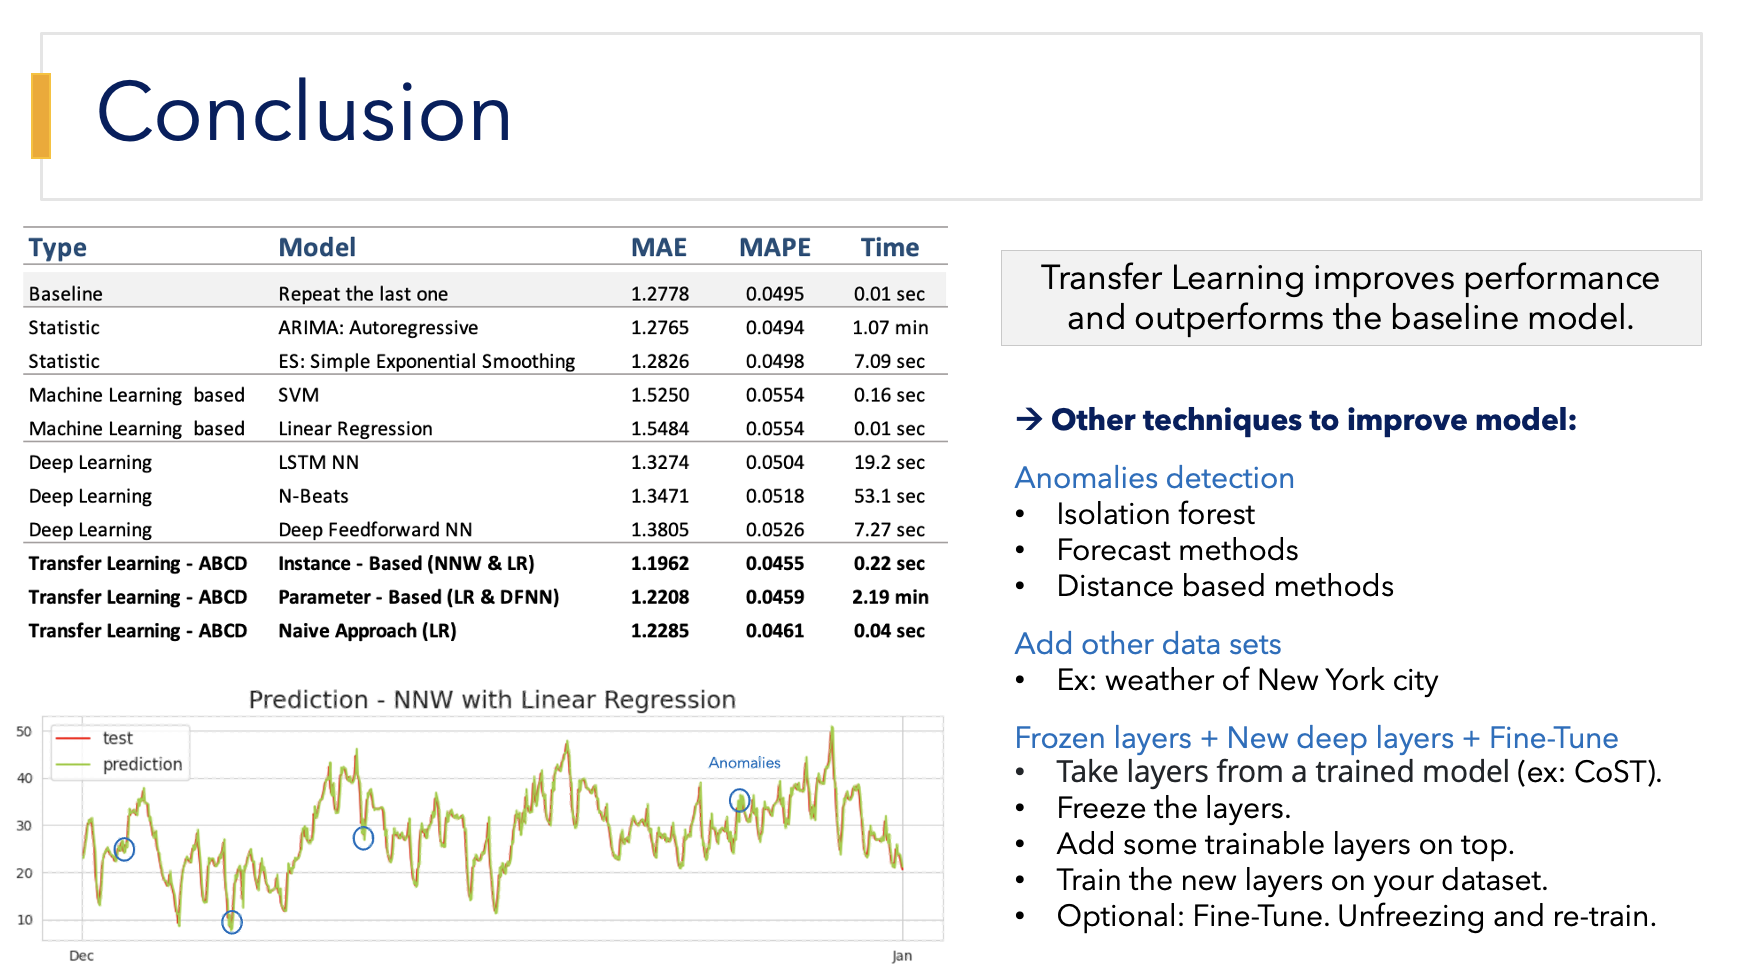